In [23]:
import os
import sys
import polars as pl
import plotly.express as px
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars.selectors as cs

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)

In [29]:
df = pl.read_parquet(os.path.join(DATA_DIRECTORY, "output", "side-by-side", "L1_1_min_sbs_period_acropolis.parquet")) \
    .sort("datetime") \
    .with_columns(diff = pl.col("gmp343_corrected") - pl.col("picarro_corrected")) \
    .group_by_dynamic("datetime", every='1h', group_by=["system_id", "system_name"]) \
    .agg([
            cs.numeric().mean(),
            pl.col("gmp343_corrected").std().alias("gmp343_corrected_std"),
            pl.col("gmp343_corrected").var().alias("gmp343_corrected_var")
        ]) \
    .sort("system_id")

In [37]:
df_sbs = df.filter(pl.col("diff").is_not_nan()) \
    .filter(pl.col("gmp343_temperature") < 32) \
    .group_by(["system_id", "system_name"]) \
    .agg([
            (pl.col("diff").mean()).alias("mean_full_deployment"),
            (np.abs(pl.col("diff"))).mean().alias("mae_full_deployment"),
            (pl.col("diff").pow(2).mean()).alias("mse_full_deployment"),
            (pl.col("diff").pow(2).mean().sqrt()).alias("rmse_full_deployment")
        ]) \
    .sort("system_id")

In [38]:
df_daily_mean = df.sort("datetime") \
    .with_columns(pl.col("datetime").dt.date().alias("date")) \
    .group_by(["date", "system_name", "system_id"]) \
    .agg([
        (pl.col("diff").mean()).alias("daily_mean"),
        (pl.col("diff").median()).alias("daily_median")
        ]) \
    .sort("system_id")
    
fig = px.scatter(df_daily_mean, x="date", y="daily_mean", color = "system_name")
fig.show()
fig = px.scatter(df_daily_mean, x="date", y="daily_median", color = "system_name")
fig.show()

In [39]:
fig = px.scatter(df, x="datetime", y="diff", color = "system_name")
fig.show()
fig = px.scatter(df_sbs, x="system_name", y="mean_full_deployment")
fig.show()
fig = px.scatter(df_sbs, x="system_name", y="mae_full_deployment")
fig.show()
fig = px.scatter(df_sbs, x="system_name", y="rmse_full_deployment")
fig.show()

In [40]:
# 144 * 10 minute intervals in 1 day - 3 * 10 min intervals in one calibration
# 24* 1h interval in 1 day

df_plot = df.sort("datetime") \
    .group_by(["system_name", "system_id"]) \
    .agg((pl.col("gmp343_corrected").count() / 24).cast(int).alias("sbs_days")) \
    .join(df_sbs, on="system_id") \
    .drop("^.*_right$") \
    .sort("system_id")

fig = px.scatter(df_plot, x="system_name", y="sbs_days")
fig.show()

In [41]:
fig = px.scatter(df_plot, x="system_name",
                 y="rmse_full_deployment", 
                 color = "sbs_days", 
                 color_continuous_scale=px.colors.sequential.Bluered_r)

fig.update_layout(
    yaxis_title='RMSE (ppm)',
    xaxis_title='System Identifier',
    title='',
)
fig.show()

In [42]:
df_plot = df_plot.rename({"rmse_full_deployment":"RMSE (ppm)", "mae_full_deployment": "MAE (ppm)", "mean_full_deployment": "MEAN (ppm)"}).with_columns(pl.lit("Munich").alias("Mid-Cost Network"))

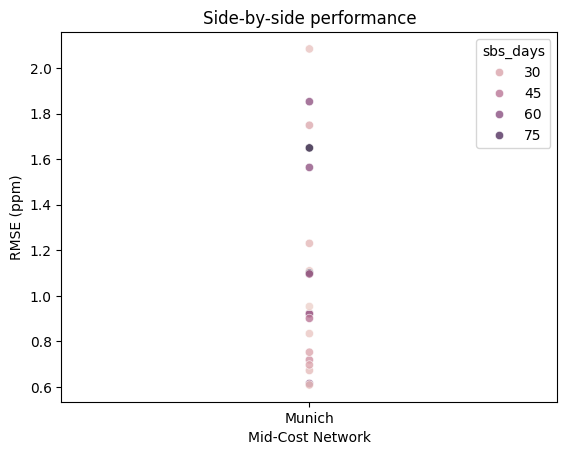

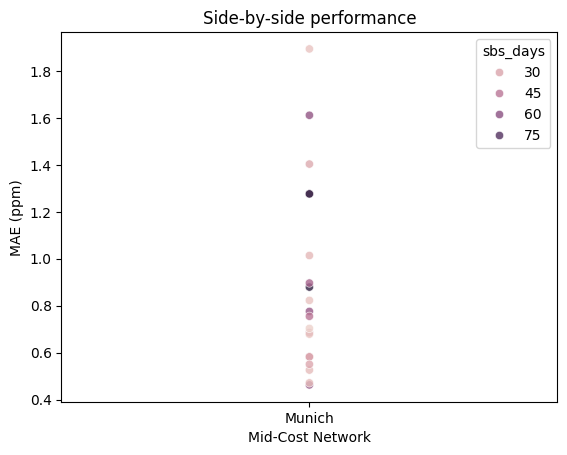

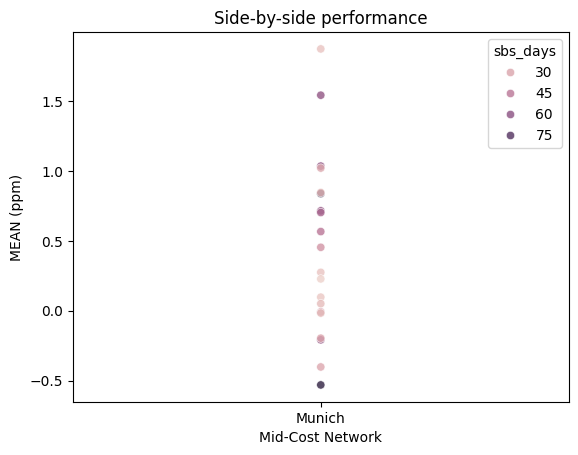

In [43]:
sns.scatterplot(data=df_plot,x='Mid-Cost Network',
                y='RMSE (ppm)', 
                hue="sbs_days", 
                alpha=0.8).set(title='Side-by-side performance')
plt.show()

sns.scatterplot(data=df_plot,x='Mid-Cost Network',
                y='MAE (ppm)', 
                hue="sbs_days", 
                alpha=0.8).set(title='Side-by-side performance')
plt.show()

sns.scatterplot(data=df_plot,x='Mid-Cost Network',
                y='MEAN (ppm)', 
                hue="sbs_days", 
                alpha=0.8).set(title='Side-by-side performance')
plt.show()